✅ Dataset awal dimuat. Jumlah baris: 138202
✅ Data transaksi masuk dipisahkan. Jumlah baris: 138086

✅ Deteksi anomali pada data BARANG MASUK selesai.
Jumlah anomali (Isolation Forest): 6900
Jumlah anomali (Rule Based): 5129
Jumlah anomali (Gabungan): 4599


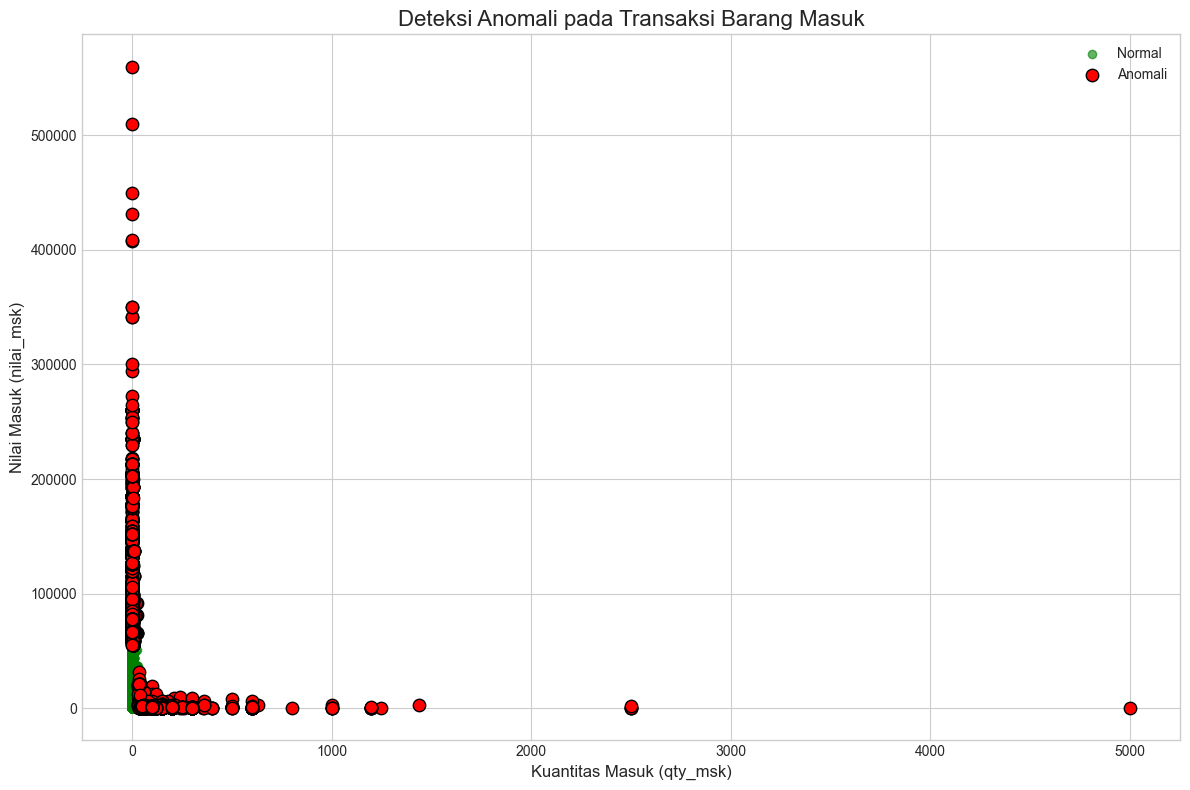


✅ Hasil deteksi (hanya anomali barang masuk) disimpan ke: hanya_anomali_barang_masuk.csv


In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- 1️⃣ Muat dataset hasil pre-processing
df = pd.read_csv("dataset_apotek_xyz_clean.csv")
print(f"✅ Dataset awal dimuat. Jumlah baris: {len(df)}")

# --- 2️⃣ PISAHKAN DATA: Fokus hanya pada transaksi BARANG MASUK
df_masuk = df[df['total_masuk'] > 0].copy()
if df_masuk.empty:
    raise ValueError("Tidak ada data transaksi masuk (total_masuk > 0) untuk dianalisis.")
    
print(f"✅ Data transaksi masuk dipisahkan. Jumlah baris: {len(df_masuk)}")

# --- 3️⃣ Deteksi Anomali pada Data Barang Masuk
# Pilih fitur yang relevan untuk transaksi masuk
numeric_cols = ['qty_msk', 'nilai_msk', 'total_masuk']
X = df_masuk[numeric_cols].fillna(0)

# Normalisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Terapkan Isolation Forest (misal, kita cari 5% transaksi masuk paling aneh)
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)
df_masuk['iforest_anomaly'] = iso_forest.predict(X_scaled)
df_masuk['iforest_anomaly'] = df_masuk['iforest_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# --- 4️⃣ Rule Based Detection (diterapkan HANYA pada df_masuk)
def rule_based_anomaly(row):
    conditions = [
        row['total_masuk'] > 10000000,  # Naikkan threshold menjadi 10 juta untuk lebih spesifik
        # Quantile sekarang dihitung HANYA pada data barang masuk, jadi lebih akurat
        row['qty_msk'] > df_masuk['qty_msk'].quantile(0.98),  # Cari top 2% qty paling ekstrem
        row['nilai_msk'] > df_masuk['nilai_msk'].quantile(0.98) # Cari top 2% nilai paling ekstrem
    ]
    return 1 if any(conditions) else 0

df_masuk['rule_based_anomaly'] = df_masuk.apply(rule_based_anomaly, axis=1)

# --- 5️⃣ Kombinasikan metode (anomali jika ditandai oleh KEDUA metode)
df_masuk['final_anomaly'] = ((df_masuk['iforest_anomaly'] == 1) & (df_masuk['rule_based_anomaly'] == 1)).astype(int)

print("\n✅ Deteksi anomali pada data BARANG MASUK selesai.")
print(f"Jumlah anomali (Isolation Forest): {df_masuk['iforest_anomaly'].sum()}")
print(f"Jumlah anomali (Rule Based): {df_masuk['rule_based_anomaly'].sum()}")
print(f"Jumlah anomali (Gabungan): {df_masuk['final_anomaly'].sum()}")

# --- 6️⃣ Visualisasi (Sekarang plot akan jauh lebih masuk akal)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot dengan warna berdasarkan final anomaly
# Data Normal (hijau)
normal_data = df_masuk[df_masuk['final_anomaly'] == 0]
ax.scatter(normal_data['qty_msk'], normal_data['nilai_msk'], 
           c='green', alpha=0.6, label='Normal')

# Data Anomali (merah)
anomaly_data = df_masuk[df_masuk['final_anomaly'] == 1]
ax.scatter(anomaly_data['qty_msk'], anomaly_data['nilai_msk'], 
           c='red', edgecolor='k', s=80, label='Anomali')

ax.set_title('Deteksi Anomali pada Transaksi Barang Masuk', fontsize=16)
ax.set_xlabel('Kuantitas Masuk (qty_msk)', fontsize=12)
ax.set_ylabel('Nilai Masuk (nilai_msk)', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

# --- 7️⃣ Simpan hasil anomali
output_path = "hanya_anomali_barang_masuk.csv"
anomaly_data.to_csv(output_path, index=False)
print(f"\n✅ Hasil deteksi (hanya anomali barang masuk) disimpan ke: {output_path}")

## 1. Penjelasan Deteksi Anomali pada Dataset Apotek XYZM (Isolation Forest)   
  
`numeric_cols = ['qty_msk', 'nilai_msk', 'qty_klr', 'nilai_klr', 'total_masuk', 'total_keluar']`  
  
Menggunakan 6 fitur numerik yang relevan:  
* qty_msk: jumlah barang masuk
* nilai_msk: nilai barang masuk
* qty_klr: jumlah barang keluar
* nilai_klr: nilai barang keluar
* total_masuk: total nilai masuk (qty_msk × nilai_msk)
* total_keluar: total nilai keluar (qty_klr × nilai_klr)

## 2. Metode Isolation Forest  
iso_forest = IsolationForest(  
    n_estimators=100,  # Jumlah pohon  
    contamination=0.05,  # Estimasi 5% data adalah anomali   
    random_state=42     # Untuk reprodusibilitas  
)  

Cara kerja:  
  
Membangun 100 pohon keputusan  
Setiap pohon mempartisi data secara acak  
Data yang "mudah diisolasi" (butuh sedikit partisi) dianggap anomali  
contamination=0.05 berarti mengasumsikan 5% data adalah anomali  

## 3. Penentuan Anomali
df['anomaly_score'] = iso_forest.decision_function(X)   # Skor anomali  
df['anomaly'] = iso_forest.predict(X)                   # Label (-1=anomali, 1=normal)  
df['final_anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)  # Convert ke binary  
  
dengan penjelasan :  
* Skor anomali negatif → lebih mungkin anomali  
* Threshold ditentukan oleh parameter contamination